Phase 3: Exploratory Data Analysis (EDA)
Objective: Uncover hidden trends, correlations, and disparities driving readmissions.

We will analyze:

The Target Variable: How rare are readmissions?

Demographics: Are certain groups at higher risk?

Medications: Does Insulin use correlate with higher severity?

Operational Metrics: How does hospital stay duration affect outcomes?

C:\Users\Acer\AppData\Local\Temp\ipykernel_16860\674618580.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded ../data/processed/diabetic_data_enriched.csv
Columns available: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_type_desc', 'discharge_desc', 'admission_source_desc', 'Primary_Diagnosis_Desc']


C:\Users\Acer\AppData\Local\Temp\ipykernel_16860\674618580.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')


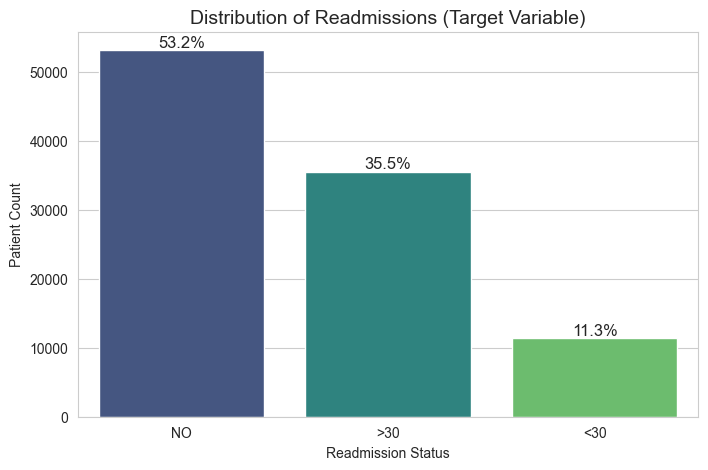

INSIGHT: If the '<30' group is small (e.g., <15%), we have a Class Imbalance problem.
This means our future model might struggle to predict it without techniques like SMOTE or class weighting.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Define the path to your file
file_path = os.path.join("../data/processed/diabetic_data_enriched.csv")

# Load the dataframe
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
    print(f"Columns available: {df.columns.tolist()}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check your folder structure.")



# --- 1. SETTING THE STYLE ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default plot size

# --- 2. THE READMISSION LANDSCAPE ---
# Insight: Checking Class Imbalance
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')
plt.title('Distribution of Readmissions (Target Variable)', fontsize=14)
plt.xlabel('Readmission Status')
plt.ylabel('Patient Count')

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

print("INSIGHT: If the '<30' group is small (e.g., <15%), we have a Class Imbalance problem.")
print("This means our future model might struggle to predict it without techniques like SMOTE or class weighting.")


Demographic Profiling
We need to see if diabetes and readmissions disproportionately affect specific age groups, races, or genders.

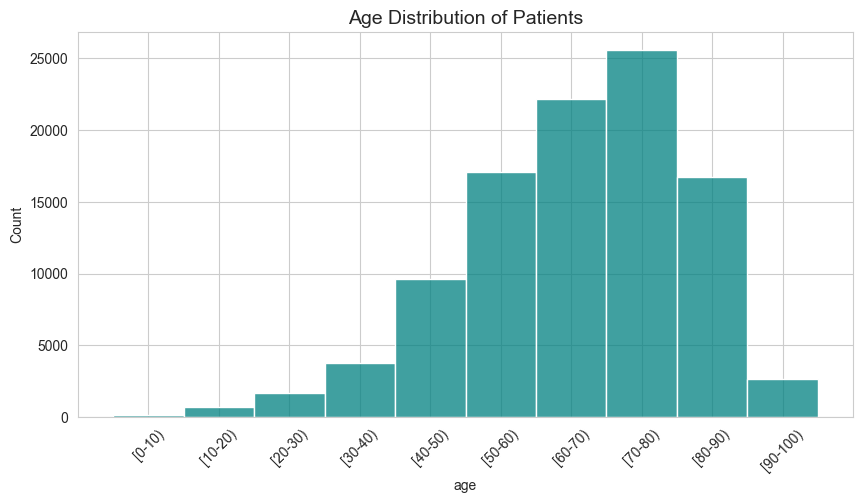

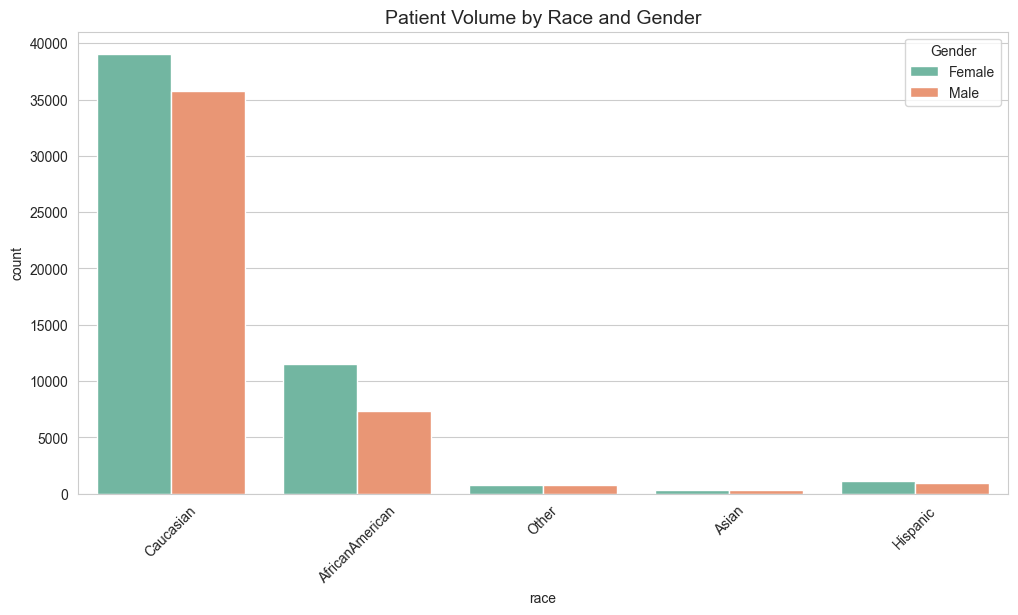

C:\Users\Acer\AppData\Local\Temp\ipykernel_16860\1783668555.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_subset['is_readmitted_early'] = (clean_subset['readmitted'] == '<30').astype(int)


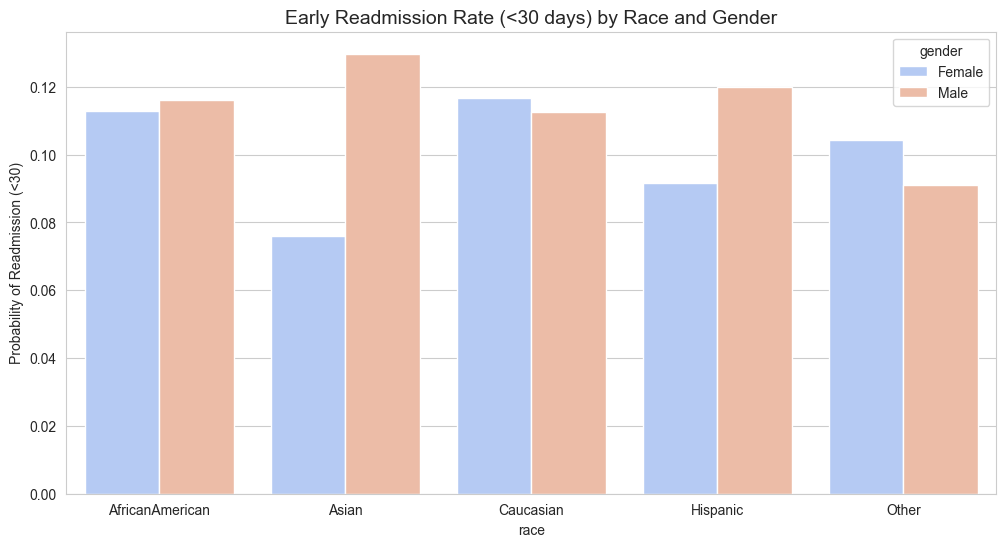

In [4]:
# --- 1. AGE DISTRIBUTION ---
plt.figure(figsize=(10, 5))
sns.histplot(df['age'].sort_values(), bins=10, kde=False, color='teal')
plt.title('Age Distribution of Patients', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# --- 2. READMISSION BY RACE AND GENDER ---
# We want to see the intersectionality. Are Black women readmitted more than White men?

# Filter out 'Unknown' or invalid gender/race entries for cleaner plots if necessary
clean_subset = df[(df['race'] != '?') & (df['gender'] != 'Unknown/Invalid')]

plt.figure(figsize=(12, 6))
# We normalize to get rates (proportions) instead of raw counts, or use countplot with hue
# A countplot shows raw numbers, which is good for volume.
sns.countplot(x='race', hue='gender', data=clean_subset, palette='Set2')
plt.title('Patient Volume by Race and Gender', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

# OPTIONAL ADVANCED: Calculate Readmission Rate (<30) by Group
# Create a binary target for calculation
clean_subset['is_readmitted_early'] = (clean_subset['readmitted'] == '<30').astype(int)

# Groupby Race and Gender to get the percentage
grouped_rates = clean_subset.groupby(['race', 'gender'])['is_readmitted_early'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='race', y='is_readmitted_early', hue='gender', data=grouped_rates, palette='coolwarm')
plt.title('Early Readmission Rate (<30 days) by Race and Gender', fontsize=14)
plt.ylabel('Probability of Readmission (<30)')
plt.show()

Medication Efficacy Analysis
Does the complexity of the medication regimen (Insulin vs. Pills) serve as a proxy for patient severity?

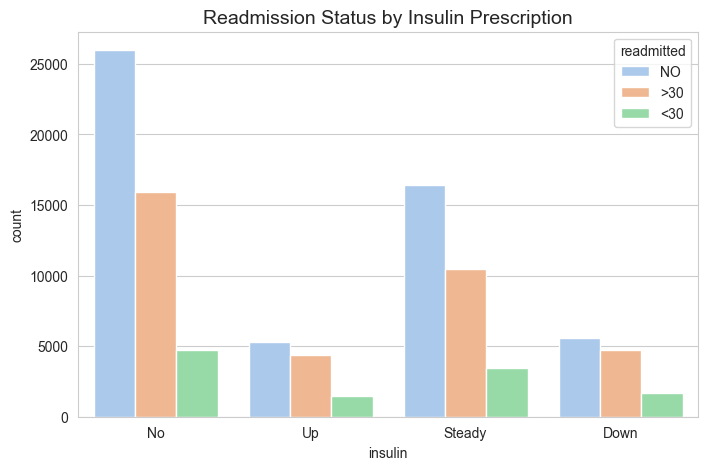

C:\Users\Acer\AppData\Local\Temp\ipykernel_16860\3628839065.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change', y='is_readmitted_early', data=df, palette='magma')


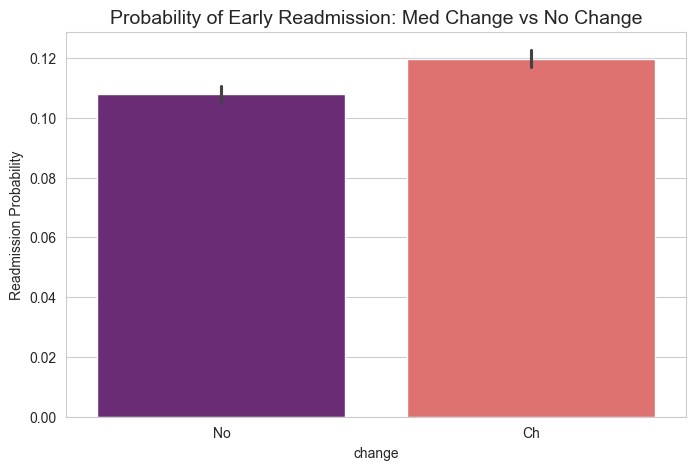

In [5]:
# --- 1. INSULIN VS OTHERS ---
# Insight: Insulin usually indicates Type 1 or advanced Type 2 diabetes.

plt.figure(figsize=(8, 5))
# Comparing Readmission rates for those on Insulin vs No Insulin
sns.countplot(x='insulin', hue='readmitted', data=df, palette='pastel', hue_order=['NO', '>30', '<30'])
plt.title('Readmission Status by Insulin Prescription', fontsize=14)
plt.show()

# --- 2. MEDICATION CHANGE ANALYSIS ---
# "Ch" indicates if medication was changed (dosage increased/decreased) during the stay.
# A change suggests the patient was not stable upon arrival.

plt.figure(figsize=(8, 5))
# We calculate the rate of early readmission (<30) for those with vs without med changes
df['is_readmitted_early'] = (df['readmitted'] == '<30').astype(int)
sns.barplot(x='change', y='is_readmitted_early', data=df, palette='magma')
plt.title('Probability of Early Readmission: Med Change vs No Change', fontsize=14)
plt.ylabel('Readmission Probability')
plt.show()


Operational Metrics & Correlation
Here we look at the hospital's efficiency. Does keeping a patient longer reduce their chance of coming back, or does it just mean they were sicker?

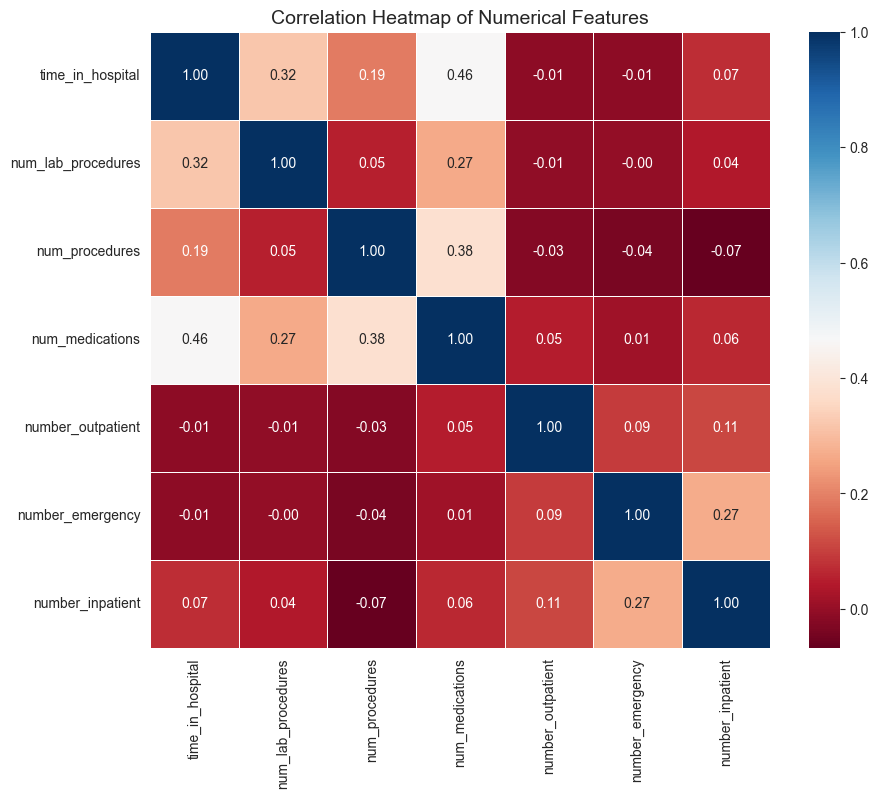

INSIGHT: Look for high correlations (dark red/blue).
If 'num_medications' and 'time_in_hospital' are highly correlated, they might carry redundant information.


C:\Users\Acer\AppData\Local\Temp\ipykernel_16860\3507329498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Set3')


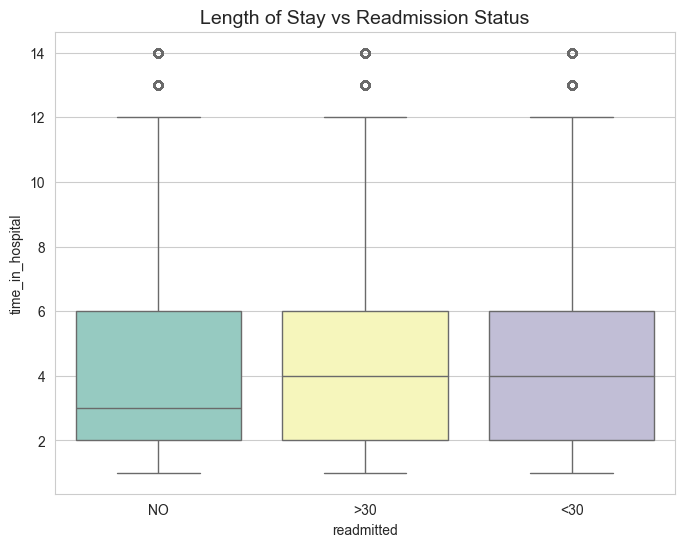

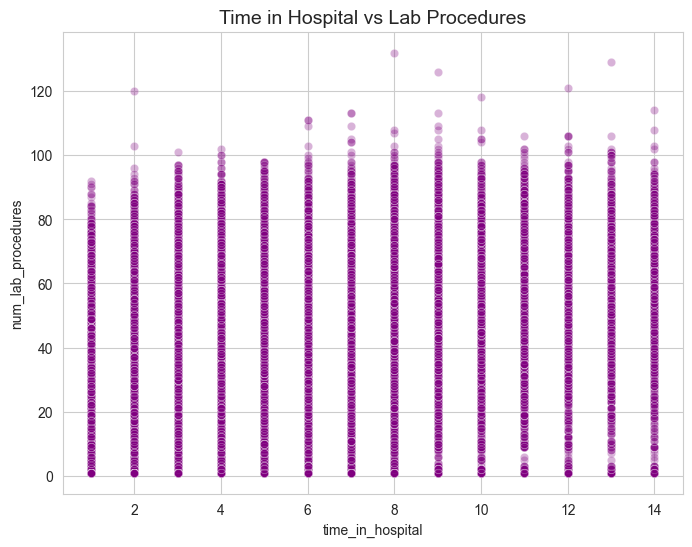

In [ ]:
# --- 1. CORRELATION HEATMAP ---
# Select only numerical columns
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                  'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.show()

print("INSIGHT: Look for high correlations (dark red/blue).")
print("If 'num_medications' and 'time_in_hospital' are highly correlated, they might carry redundant information.")

# --- 2. TIME IN HOSPITAL VS READMISSION (BOX PLOT) ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Set3')
plt.title('Length of Stay vs Readmission Status', fontsize=14)
plt.show()

# --- 3. SCATTER PLOT: TIME vs LABS ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x='time_in_hospital', y='num_lab_procedures', data=df, alpha=0.3, color='purple')
plt.title('Time in Hospital vs Lab Procedures', fontsize=14)
plt.show()
